### Задание 4.1

В наших данных использования ленты новостей есть два типа юзеров: те, кто пришел через платный трафик source = 'ads', и те, кто пришел через органические каналы source = 'organic'.

Необходимо проанализировать и сравнить Retention этих двух групп пользователей. Решением этой задачи будет ответ на вопрос: отличается ли характер использования приложения у этих групп пользователей. 
 

In [4]:
# Выгрузим необходимые данные из БД
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'****'
                     }

query = '''
    SELECT        
        toDate(first_action_time) as first_action_day
        ,toDate(time) as day
        ,toDate(time)-toDate(first_action_time) as number_of_day
        ,source
        ,count(DISTINCT user_id) as users_count
    FROM
        (SELECT  
            user_id
            ,time
            ,min(time) over(partition by user_id) as first_action_time
            ,source
            ,exp_group 
        FROM {db}.feed_actions
        WHERE toDate(time) < today()) as t
    GROUP BY
        toDate(time)
        ,toDate(first_action_time)
        ,source
'''

df = pandahouse.read_clickhouse(query, connection=connection).sort_values(by = ['first_action_day', 'number_of_day']).reset_index(drop = True)
# Проверим, загрузилось ли
df.head()

,first_action_day,day,number_of_day,source,users_count
0,2023-06-03,2023-06-03,0,ads,799
1,2023-06-03,2023-06-03,0,organic,79
2,2023-06-03,2023-06-04,1,organic,40
3,2023-06-03,2023-06-04,1,ads,379
4,2023-06-03,2023-06-05,2,organic,36


На всякий случай:
* 'number_of_day' – это количество дней с даты первой активности (т.е. разница между колонками 'day' и 'first_action_day')
* 'users_count' – количество пользователей

In [5]:
# Оценим различие в количестве пользователей по каналу их привлечения
df[df['number_of_day'] == 0].groupby('source').users_count.sum() 

source
ads        98017
organic    61512
Name: users_count, dtype: uint64

Из обоих источников привлечено почти одинаковое количество пользователей. 

***
Ранее мы с помощью Superset построили тепловые карты, визуализирующие retention обеих групп по дням использования:

![Рисунок](/Users/nikitasmirnov/SimDA_KarpovCourses/2.ProductMetrics/Retention1.png)

При сравнении соответствующих друг другу столбцов и диагоналей обоих графиков создается впечатление, что retention rate у пользователей из органических каналов в основном выше, чем у тех, кто пришел из платных.

Чтобы в этом убедиться, для обеих групп пользователей посчитаем *усредненный retention* каждого дня с момента начала использования ленты новостей.

In [6]:
#Добавляем к выгруженным данным столбец с количеством пользователей первого дня
source_retention = df.merge(df[df.day == df.first_action_day][['first_action_day', 'source', 'users_count']]\
                       .rename(columns={'users_count' : 'first_day_users'}), on = ['first_action_day', 'source'])

# Суммируем users_count и first_day_users по номеру дня и источнику трафика
source_retention = source_retention.groupby(['source', 'number_of_day'], as_index = False).agg({'users_count':'sum', 'first_day_users':'sum'})

#Добавляем столбец c retention rate
source_retention['retention'] = round(source_retention['users_count']/source_retention['first_day_users'] * 100, 2)

#Создадим сводную таблицу для удобства
pivoted_source_retention = source_retention.pivot(index = 'number_of_day', columns = 'source', values=['retention'])['retention']
pivoted_source_retention['difference'] = pivoted_source_retention['organic'] - pivoted_source_retention['ads']
#Посмотрим на некоторые дни
pivoted_source_retention.iloc[[0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50]]

source,ads,organic,difference
number_of_day,,,
0,100.00,100.00,0.00
1,36.67,43.60,6.93
5,28.35,35.45,7.10
10,19.82,26.77,6.95
15,13.28,19.80,6.52
20,9.79,15.85,6.06
25,7.68,14.26,6.58
30,7.49,14.35,6.86
35,7.48,14.16,6.68


In [7]:
print(f'В среднем retention у пользователей из органических каналов выше на {round(pivoted_source_retention.difference.mean(), 2)} процентных пункта')

В среднем retention у пользователей из органических каналов выше на 6.62 процентных пункта


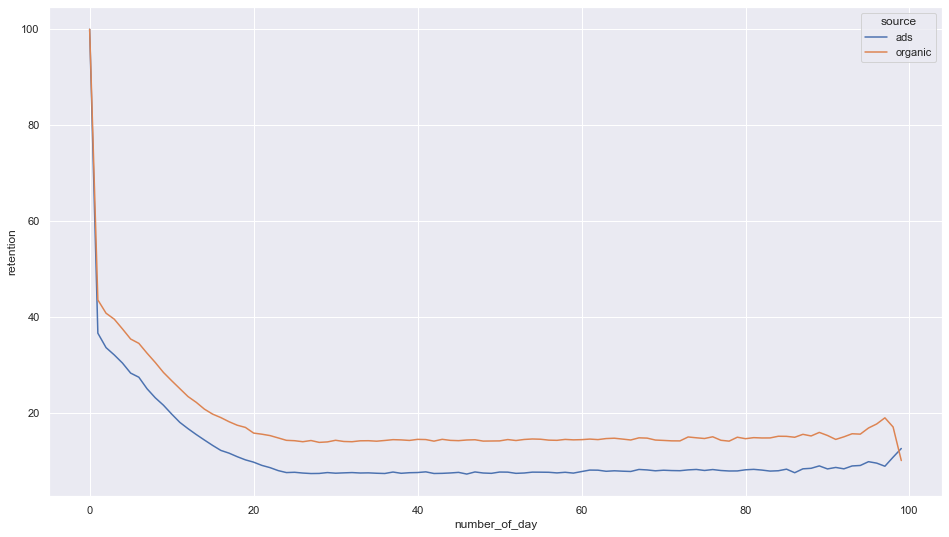

In [8]:
# Визуализируем для наглядности

sns.set(rc = {'figure.figsize':(16, 9)})

ax = sns.lineplot(
    data=source_retention,
    y="retention", x="number_of_day",
    hue="source")


#### Выводы

1) Пользователи из платных каналов привлечения в меньшей степени склонны продолжать использовать ленту новостей нашего сервиса. Их retention rate в среднем существенно ниже для каждого дня, следующего за первым посещением ленты, чем у тех, кто пришел из органических каналов. 

>Исключением может быть retention последнего дня, который рассчитывается на основе количества пользователей самого первого дня существования продукта, когда из органических каналов пришли лишь 79 пользователей, в связи с чем это значение сильно "шумит".

2) Спустя примерно 25 дней с первого посещения ленты новостей retention rate обеих групп перестает значительно изменяться. У пользователей из органических каналов он фиксируется на уровне около 14%, а из платных – 8%.

***